In [341]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

<b>Import</b>

In [342]:
df = pd.read_csv("MSFT.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


<b>Cleanup</b>

In [343]:
#According to Correlation/phiks matrix, volume is pretty useleless and has low relevance, imma drop it like its hot
df=df.drop('Low',axis=1)
df=df.drop('Close',axis=1)
df.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

#trusting the autoviz blindly i will cap some outliers?
df['Open'] = df['Open'].clip(lower=-55, upper=97)
df['High'] = df['High'].clip(lower=-55, upper=97)
df['Volume'] = df['Volume'].clip(lower=-22460000, upper=129717000)
df['Adj_Close'] = df['Adj_Close'].clip(lower=-45, upper=75)


# Useless Legacy Code to show my errors, later everythign except the 2 targt varables get dropped anyways



#correlation is probably a bit unreliable since all the data has the same distribution
# i can probabbly drop everything except 1 sicne the distribution and correlation is almost the same
# but yk that prob wouldnt be that fun

In [344]:
df.head()

,Date,Open,High,Adj_Close,Volume
0,1986-03-13,0.088542,0.101563,0.061434,129717000
1,1986-03-14,0.097222,0.102431,0.063628,129717000
2,1986-03-17,0.100694,0.103299,0.064725,129717000
3,1986-03-18,0.102431,0.103299,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.061982,47894400


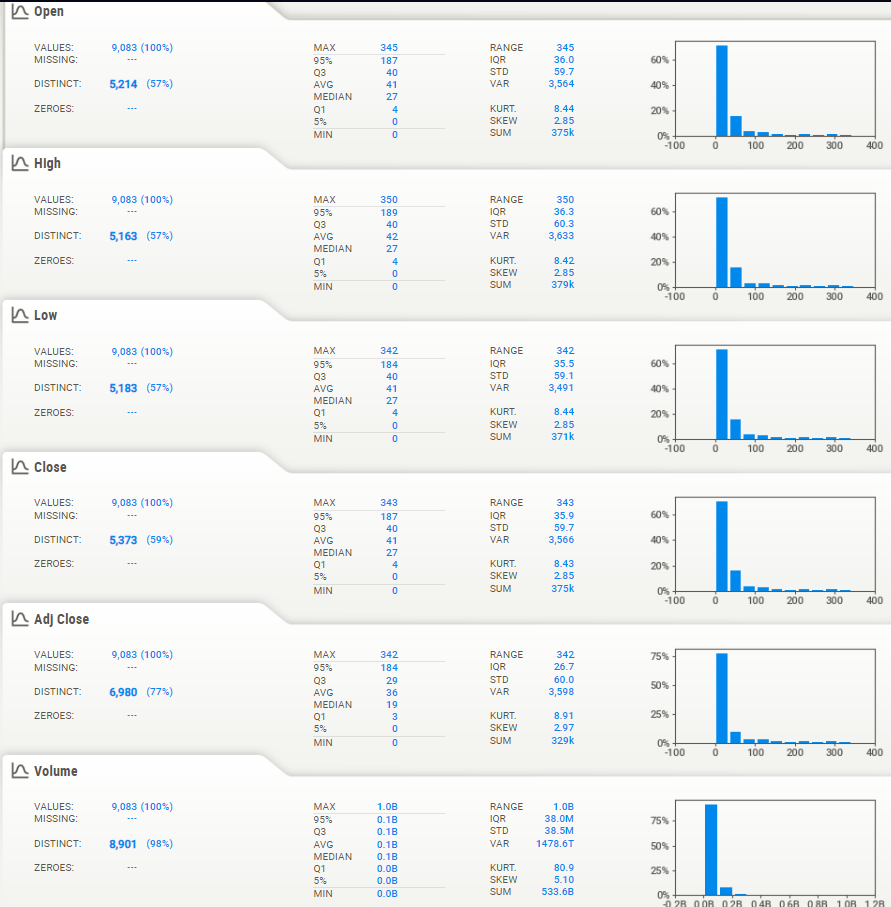

<b>seperation</b>

In [345]:
#Legacy Code: i messed up by thinking for time series we need seperated train test from the begnning, so i looked at stack overflow to see how to split it



#train_set, test_set= np.split(df, [int(.67 *len(df))])
#df1=train_set
#df2=test_set
#i know i could have just set df1,df2 instead of train_set for simplifying, but i didnt want to loose overwie of wich is the train wich is the test




In [346]:
df.head()

,Date,Open,High,Adj_Close,Volume
0,1986-03-13,0.088542,0.101563,0.061434,129717000
1,1986-03-14,0.097222,0.102431,0.063628,129717000
2,1986-03-17,0.100694,0.103299,0.064725,129717000
3,1986-03-18,0.102431,0.103299,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.061982,47894400


In [347]:
df.describe()

,Open,High,Adj_Close,Volume
count,9083.000000,9083.000000,9083.000000,9.083000e+03
mean,31.332719,31.566163,24.046986,5.678453e+07
std,29.263914,29.309335,23.742183,2.898446e+07
min,0.088542,0.092014,0.057046,2.304000e+06
25%,4.050781,4.102051,2.575089,3.461230e+07
50%,26.820000,27.100000,18.948530,5.203200e+07
75%,40.034999,40.443751,29.244812,7.265400e+07
max,97.000000,97.000000,75.000000,1.297170e+08


In [348]:
# this dataformat is not suitable yet for CNN time series classification
# because each point is separate in the dataset

# we have to process the data into smaller chunks -> for example
# chunks of 50 points at a time

# we are going to select High Low as targets in run 1, sicne those are the min max of the day, i think maybe the cnn can wortk best with taht?
df = df.drop(['Open','Adj_Close'], axis=1)



1. Run tagerg variables low and high
2. run high and volume

In [349]:
df.head()

,Date,High,Volume
0,1986-03-13,0.101563,129717000
1,1986-03-14,0.102431,129717000
2,1986-03-17,0.103299,129717000
3,1986-03-18,0.103299,67766400
4,1986-03-19,0.100694,47894400


<b>Value scale</b>

In [350]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# cale only relevant variables
num_cols = ['High', 'Volume']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [351]:
df.head()

,Date,High,Volume
0,1986-03-13,0.000099,1.000000
1,1986-03-14,0.000107,1.000000
2,1986-03-17,0.000116,1.000000
3,1986-03-18,0.000116,0.513781
4,1986-03-19,0.000090,0.357816


In [352]:
df['sequence'] = df.index + 1
df = df.drop(['Date'], axis=1)

In [353]:
df.tail()

,High,Volume,sequence
9078,1.0,0.321890,9079
9079,1.0,0.204431,9080
9080,1.0,0.198533,9081
9081,1.0,0.183744,9082
9082,1.0,0.173788,9083


<b>Timestamps</b>

<p>I am not sure what to use windows or timeframes, sicne i have 9k data, imma use both to compare, pretty sure in the excercise we should do both anyway</p>
<s>Sometimes when writing these messages i feel like i am not erious enough, and that that might affect my grade, but alsoits after midnight so yeah gotta keep my mood somehow shrugy</s>

In [354]:
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 10

# separate the output variables
high = df['High'].values
var2 = df['Volume'].values

# generate timestep windows for each signal

# for separate timesteps, add [::timestep_size] for each dataset (meantemp_windows, wind_speed_windows)
# e.g. meantemp_windows = sliding_window_view(meantemp, window_shape=timestep_size)[::timestep_size]
# this filters every 50th (timestep_size) of a Python list
# which results into a set of timesteps with no overlap! (in sequence)

# RULE OF THUMB! If you have lots of data => use separate timesteps to avoid redundancy in data
# If you lack data, use sliding window instead (to get more data, but also having redundancy introduced)
# using separate time steps will also discard any extra data that doesn't fill the final timestep
# in this case, there's 25 extra measurements in the end, and since timestep_size is 50, these 25 are discarded
high_windows = sliding_window_view(high, window_shape=timestep_size)[::timestep_size]
var2_windows = sliding_window_view(var2, window_shape=timestep_size)[::timestep_size]

# combine into X and y
# use vstack to combine temperatures and wind speeds back together
X = np.vstack((high_windows, var2_windows))

# generate zeroes and ones for the output categories
# 0 = meantemp
# 1 = wind_speed
y = np.array([0] * len(high_windows) + [1] * len(var2_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (1816, 10)
y: (1816,)


timewindow reduced to 10 to have more than 900 data to fit the modell

In [355]:
from sklearn.utils import shuffle

# shuffle the data
X, y = shuffle(X, y, random_state=42)

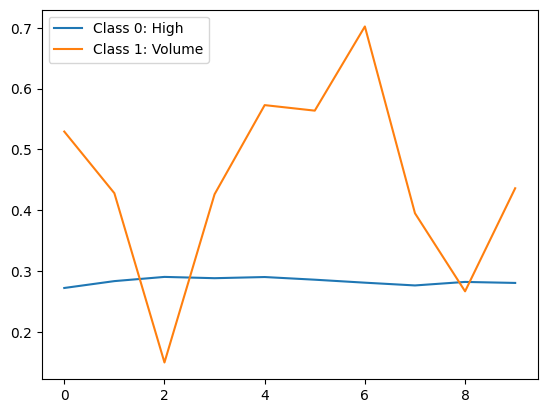

In [356]:
test_signal_index = 2

c_x_train = X[y == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0: High")

c_x_train = X[y == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1: Volume")
plt.legend()

weird that the "highest sell price for the day" is lower than the "lowest sellprice for the day" ?

2. run way more sensible with the new variables

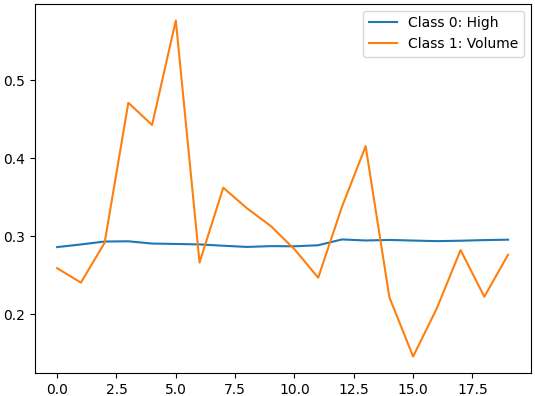

<b>Train Split</b>

In [357]:
 # define the cutoff point
train_size = 0.7
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [358]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

1271
545
1271
545


In [359]:
# convert the data into the required CNN -format
# usuallu the easiest approach is to modify
# your own data to follow the data format used by another example 
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [360]:
class_names = np.array(["High", "Volume"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(64, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [361]:
epochs = 200
#batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.5983 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.6891 - val_sparse_categorical_accuracy: 0.5294
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4601 - sparse_categorical_accuracy: 0.7767 - val_loss: 0.6740 - val_sparse_categorical_accuracy: 0.5412
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4061 - sparse_categorical_accuracy: 0.8009 - val_loss: 0.6731 - val_sparse_categorical_accuracy: 0.5137
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3484 - sparse_categorical_accuracy: 0.8379 - val_loss: 0.7086 - val_sparse_categorical_accuracy: 0.5137
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2798 - sparse_categorical_accuracy: 0.9251 - val_loss: 0.7881 - val_sparse_categorical_accuracy: 0.5137
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2291 - sparse_categorical_accuracy: 0.9483 - val_loss: 0.8699 - val_sparse_categorical_accuracy: 0.5137
Epoch 7/2

<Axes: >

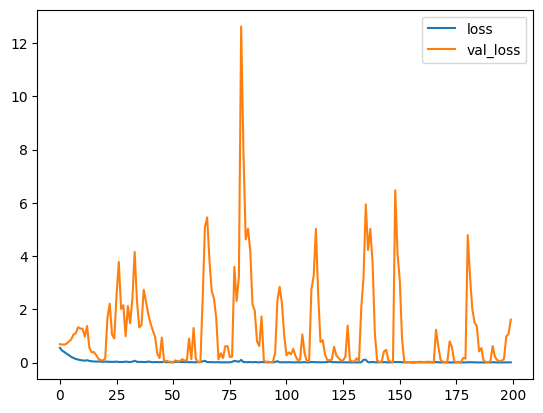

In [362]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<b>1. run</b>
honestly, i am not suprised anymore, wtf?
okay yeah is to be expected since stock is not really predictable

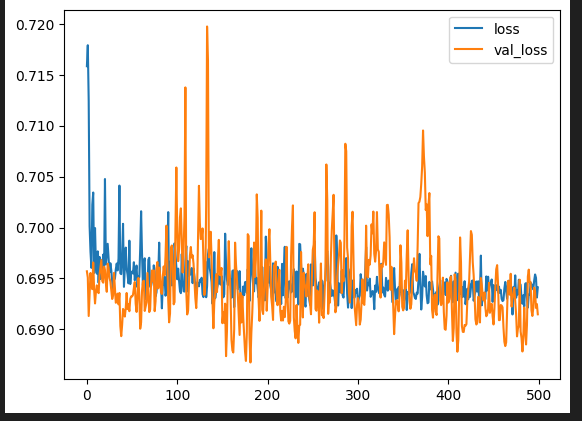

<b>2. Run</b>
When is christmas? cuz this looks like a sleigh

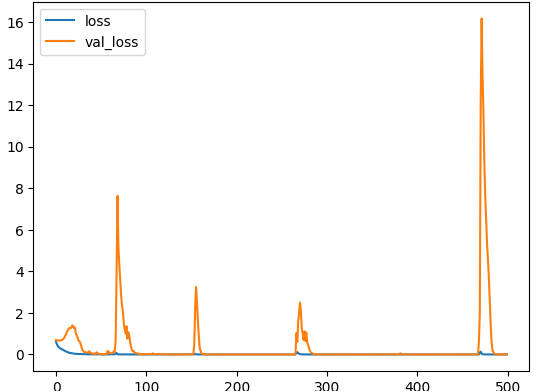

<b>3.</b> seems like the modell is already full fitted after 150 epochs, i also dont understand why there is only 900 data when the set has 9k rows

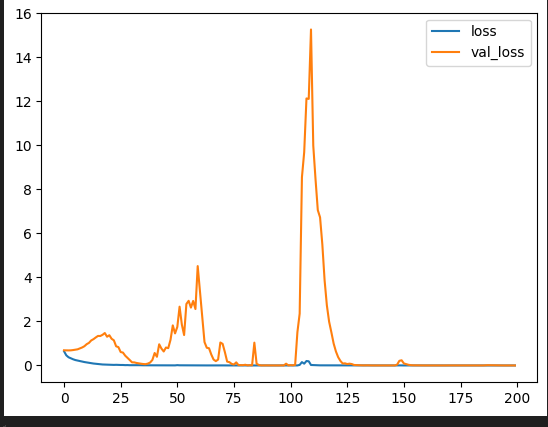

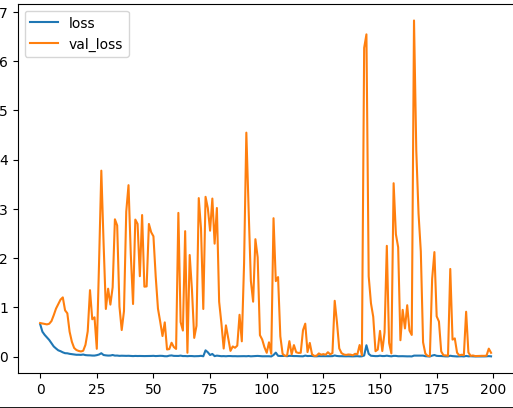

<Axes: >

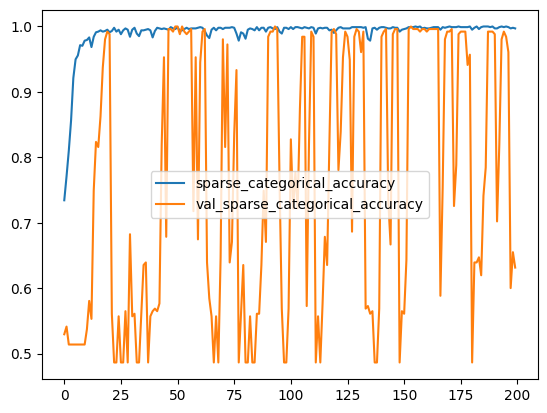

In [363]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

<b>1.</b>
yeah i guess at least a bit system in the chaos

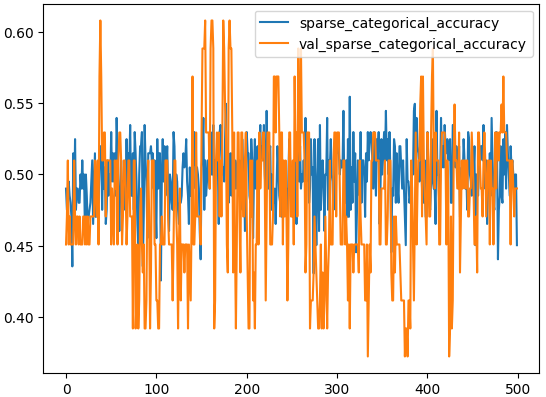

<b>2. run</b>
ye idk

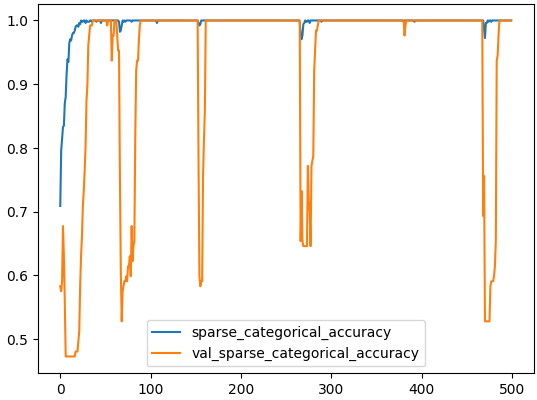

<b>3.</b>Ye big difference with the timeframe reduction, the modell isnt trained that fast to all the data there is

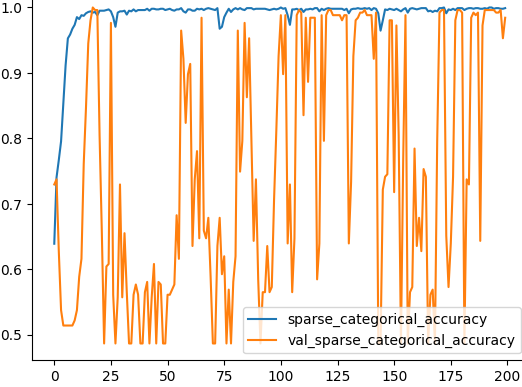

In [364]:
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[1.5713976621627808, 0.642201840877533]

Train data evaluation:
[1.7267975807189941, 0.6073957681655884]


<b>2. Run</b>
<p>Test data evaluation:
[0.00018711223674472421, 1.0]

Train data evaluation:
[0.00017985064187087119, 1.0]</p>
<p>It seems the modell is oerfittet since it knows our data perfect but cant do predictions, so imma reduce the epochs to 250</p>
<b>3. Run</b>
<p>Test data evaluation:
[0.04581020399928093, 0.9926605224609375]

Train data evaluation:
[0.05766771361231804, 0.989771842956543]</p>
<p>Finally not a 1.0 anymore</p>

In [365]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<Axes: >

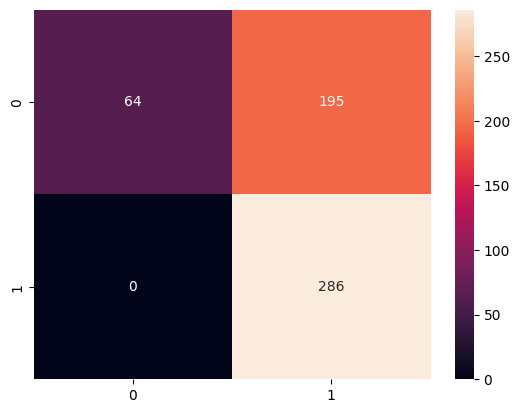

In [366]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

<b>1.</b>
<p>I am not sure if the confusion matrix is usable since high is highest price, and low is lowest price, so its not really a cathegory to put into, so true negative and true positive make nosense?
<br>Anyway 0 = high so 41 where correctly classieief as high ????? the longer i try to interpret it the more it seems not working?
<br> 10 where said as high but where low ?????
<br>8 correct low and 50 incorrect low?????
</p>

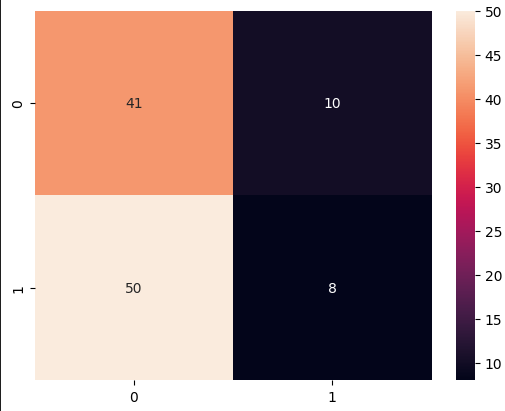

<b>2.</b>
<p>100% accuracy, wich makes sense sincethe numbers of the2 cathegorys are so different</p>

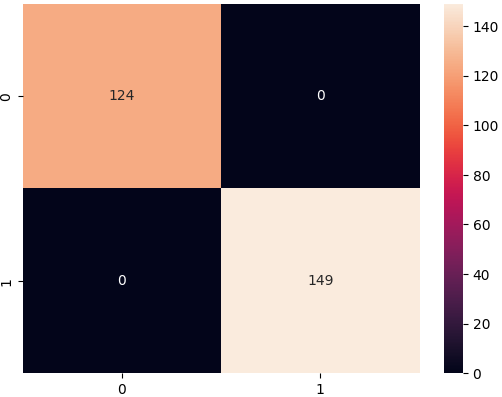

<b>3.</b>
<p>A bit isscathegorization in class 0 but feels better for some reason</p>

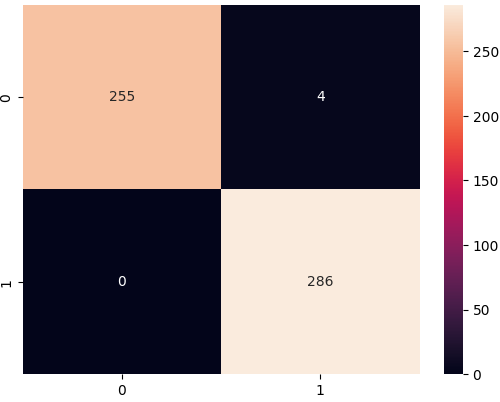

In [367]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40       259
           1       0.59      1.00      0.75       286

    accuracy                           0.64       545
   macro avg       0.80      0.62      0.57       545
weighted avg       0.79      0.64      0.58       545


Model overall accuracy: 64.22%


<ul><b>Notes</b>
<li>1. Run <ul>
<li><p>Most of the high confusion matrix is correct, most of the low confusion matrix is Wrong </p></li>
<li>Overall: <ul>
<li>Precicion: for all clases over 45%</li> 
<li>Recall: for 0 is 0.80 and 1 is 14% wich is not really good</li>
<li>F1:58% and 21%</li>
<li>Overall accuracy 45% wich is awefull, and flipping a coin would be better, this is to be expected since it is stocks and also because the correlation is basically 1</li></ul></li>
</ul></li>
<li>2. Run <ul>
<li><p>Confusion matrix 100% </p></li>
<li>Overall: <ul>
<li>Precicion: 1</li> 
<li>Recall: 1</li>
<li>F1:1</li>
<li>1</li></ul></li>
</ul></li>
<li>3. Run <ul>
<li>Overall: <ul>
<li>Precicion: 99%</li> 
<li>Recall: 99%</li>
<li>F1:99%</li>
<li>99%</li></ul></li>
</ul></li>
</ul>

<b>Test the model</b>

0
High


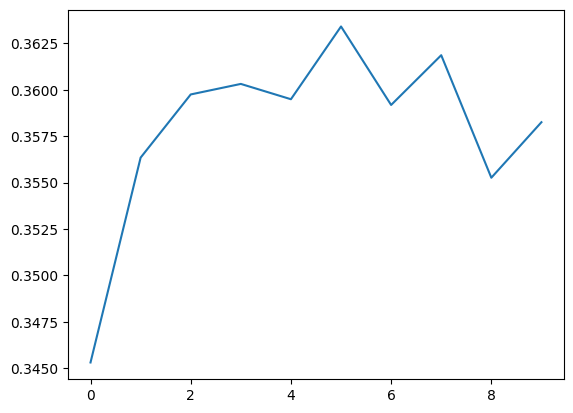

In [369]:
signal_index = 120
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

<b>1. Run</b>
<b>1. 60</b>
<p>Classification as Low</p>
<b>2.80</b>
<p>Classification High</p>
<b>2.Run</b>
<p>120 = Classification as high</p>
<p>544 = Class as Volume</p>


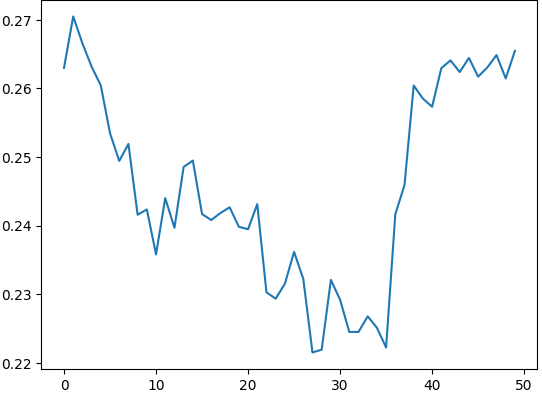
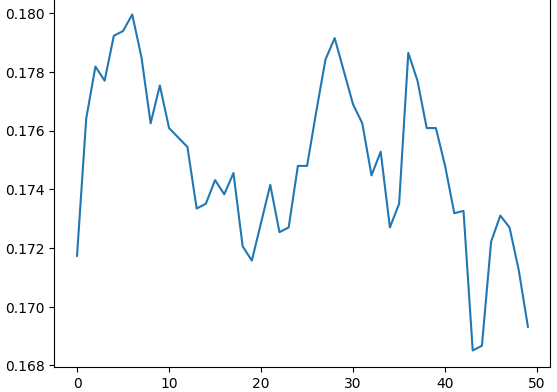

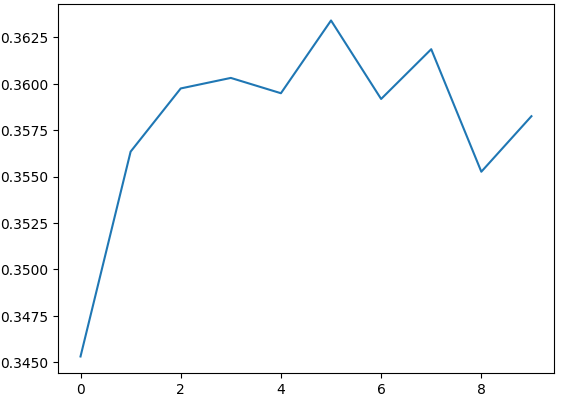
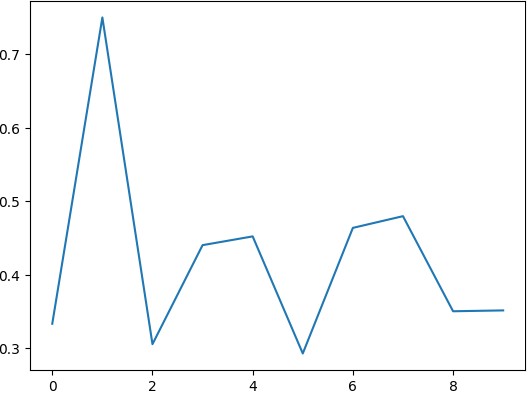